## IBM Machine Learning Course Lab 7 - Logistic Regression

This is my own attempt at Lab 7 of 'Machine Learning with Python' by IBM on Coursera. It includes my own insight when solving problems. The method of analysis presented here is far more rigorous than that required by the course.

In [1]:
""" importing necessary packages """
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
""" Importing the data set """

!wget -O ChurnData.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/ChurnData.csv
df = pd.read_csv("ChurnData.csv")
df.head(10)


--2020-08-12 16:06:29--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/ChurnData.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36144 (35K) [text/csv]
Saving to: ‘ChurnData.csv’

ChurnData.csv       100%[===================>]  35.30K   121KB/s    in 0.3s    

2020-08-12 16:06:31 (121 KB/s) - ‘ChurnData.csv’ saved [36144/36144]



,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0
5,68.0,52.0,17.0,120.0,1.0,24.0,0.0,1.0,0.0,20.70,...,0.0,0.0,0.0,0.0,0.0,3.030,3.240,4.787,1.0,0.0
6,42.0,40.0,7.0,37.0,2.0,8.0,1.0,1.0,1.0,8.25,...,0.0,1.0,1.0,1.0,1.0,2.110,3.157,3.611,4.0,0.0
7,9.0,21.0,1.0,17.0,2.0,2.0,0.0,0.0,0.0,2.90,...,0.0,0.0,0.0,0.0,0.0,1.065,3.240,2.833,1.0,0.0
8,35.0,50.0,26.0,140.0,2.0,21.0,0.0,1.0,0.0,6.50,...,0.0,0.0,1.0,1.0,0.0,1.872,3.314,4.942,3.0,0.0
9,49.0,51.0,27.0,63.0,4.0,19.0,0.0,1.0,0.0,12.85,...,0.0,1.0,1.0,0.0,1.0,2.553,3.248,4.143,2.0,0.0


## Data Exploration and Preparation

In [8]:
df.info()
df.shape

#the logistic regression functions require that the target variable is an integer, from df.info() we
#see that is it a float, so we must change it to an integer

df[['churn']] = df[['churn']].astype('int')

#converting from df to array
columns = df.columns.values
columns = np.delete(columns,[len(columns)-1])

X = np.asarray(df[columns]) #note, the IBM course only uses ['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']
#in the X data, let's see what happens when we include all of them!

y = np.asarray(df[['churn']])
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   longmon   200 non-null    float64
 10  tollmon   200 non-null    float64
 11  equipmon  200 non-null    float64
 12  cardmon   200 non-null    float64
 13  wiremon   200 non-null    float64
 14  longten   200 non-null    float64
 15  tollten   200 non-null    float64
 16  cardten   200 non-null    float64
 17  voice     200 non-null    float64
 18  pager     200 non-null    float64
 19  internet  200 non-null    float64
 20  callwait  200 non-null    float6

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,55.0,44.0,24.0,83.0,1.0,23.0,0.0,1.0,0.0,17.35,...,0.0,0.0,0.0,1.0,0.0,2.854,3.199,4.419,3.0,0
196,34.0,23.0,3.0,24.0,1.0,7.0,0.0,1.0,0.0,6.00,...,0.0,0.0,1.0,1.0,0.0,1.792,3.332,3.178,3.0,0
197,6.0,32.0,10.0,47.0,1.0,10.0,0.0,1.0,0.0,3.85,...,0.0,0.0,1.0,1.0,0.0,1.348,3.168,3.850,3.0,0
198,24.0,30.0,0.0,25.0,4.0,5.0,0.0,1.0,1.0,8.70,...,1.0,1.0,1.0,1.0,1.0,2.163,3.866,3.219,4.0,1


In [4]:
#normalize data set

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split as tts

X = pp.StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = tts( X, y, test_size=0.2, random_state=4)
print(X_train)

[[ 1.08839657  0.14067695 -0.75495974 ...  0.03858151  0.88452453
  -0.44114529]
 [ 0.85677355  0.06401376 -1.14970993 ...  2.80688971  0.07458016
   1.41630855]
 [ 0.94942275  0.9073088   1.12010367 ...  0.03858151  0.87120307
  -0.44114529]
 ...
 [ 0.71779974  0.60065606  1.71222895 ...  0.03858151 -0.19184891
  -1.36987221]
 [-1.50578124 -0.7026181  -0.75495974 ... -1.6844763   0.14518386
   1.41630855]
 [-0.53296457 -0.47262854 -0.16283445 ...  0.03858151 -0.31573843
  -0.44114529]]


## Modelling - Logistic Reg.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

#regularization is a technique used to prevent overfitting. C is the inverse of it's strength.

#higher C == weaker regulairzation so more overfit
#solver is the type of algorithm that you want the model to use

yhat = LR.predict(X_test)
print(yhat) #the output is essentially the designated 'classes that it predicted for the X_test'

#compare them with y_test
print(y_test.tolist())
#there are many mispredicted values!!!!

yhat_prob = LR.predict_proba(X_test)
print(yhat_prob) # the outcome is very odd... so the first one is the prob. of class 0, and the second of class 1?


[0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1
 0 0 1]
[[0], [0], [1], [0], [1], [1], [1], [0], [1], [1], [0], [0], [0], [1], [0], [0], [1], [1], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0], [1], [1], [0], [0]]
[[0.60722328 0.39277672]
 [0.61809654 0.38190346]
 [0.58411229 0.41588771]
 [0.65417657 0.34582343]
 [0.57846128 0.42153872]
 [0.60571723 0.39428277]
 [0.49465243 0.50534757]
 [0.63096405 0.36903595]
 [0.37261192 0.62738808]
 [0.57501555 0.42498445]
 [0.43796261 0.56203739]
 [0.56949003 0.43050997]
 [0.52659009 0.47340991]
 [0.38212909 0.61787091]
 [0.68571532 0.31428468]
 [0.52974013 0.47025987]
 [0.49534501 0.50465499]
 [0.54486783 0.45513217]
 [0.42671406 0.57328594]
 [0.58188784 0.41811216]
 [0.50068924 0.49931076]
 [0.41069809 0.58930191]
 [0.80418638 0.19581362]
 [0.34302289 0.65697711]
 [0.43713534 0.56286466]
 [0.75147663 0.24852337]
 [0.39496994 0.60503006]
 [0.42173992 0.57826008]
 [0.53615371 0.4

/Users/yousefnami/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Evaluation

In [6]:
from sklearn.metrics import jaccard_similarity_score
print(jaccard_similarity_score(y_test, yhat))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, yhat))

#why are they both the same lmao...


0.625
0.625


/Users/yousefnami/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


[[ 7  8]
 [ 7 18]]
Confusion matrix, without normalization
[[ 7  8]
 [ 7 18]]
              precision    recall  f1-score   support

           0       0.69      0.72      0.71        25
           1       0.50      0.47      0.48        15

    accuracy                           0.62        40
   macro avg       0.60      0.59      0.59        40
weighted avg       0.62      0.62      0.62        40



0.6328239710889156

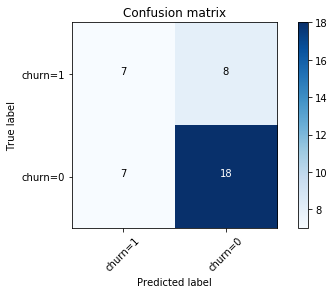

In [7]:
""" This portion has been copied from the IBM course without any of my own input"""

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')



print (classification_report(y_test, yhat))


from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)


#NOTE: my method of using ALL the data yields a lower accuracy score than what the IBM lab gets.
#I wonder, is there any sort of data exploration that you can do for classification problems?

#I presume one thing you can try is, if you plot the distributions for churn = 1 and 0, and then the dist
#for all the other ones, I presume those with similar distributions will be related? Not sure...


## Conclusion

This is a difficult, yet very interesting topic. Need to start playing around with it myself :)
